In [58]:
# Time for Greedy versus e-greedy example
import numpy as np
import random

def greedy_action_rule(_qv):
    return np.argmax(_qv)

def e_greedy_rule(_qv, e_value):
    if random.uniform(0, 1.0) > e_value:
        print("EXPLOIT")
        return greedy_action_rule(_qv)
    else:
        print("EXPLORE")
        return random.randint(0, len(_qv) - 1)

# Preparation
number_of_arms = 5
q_values = np.zeros(shape=(number_of_arms, 1))
q_values[2] = 5

# Greedy strategy
print(q_values)
greedy_action_rule(q_values)

# e-greedy strategy
for i in range(5):
    e_greedy_rule(q_values, 0.5)

[[0.]
 [0.]
 [5.]
 [0.]
 [0.]]
EXPLORE
EXPLOIT
EXPLOIT
EXPLOIT
EXPLOIT


In [59]:
# Configuration
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys, warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 8)
%load_ext autoreload
%autoreload 2
np.random.seed(5) # for reproduction

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
# Define environment class
class Environment:
    def __init__(self, arm_count = 10, mean = 0.0, stddev = 1.0):
        self.arm_count = arm_count
        self.mean = mean
        self.stddev = stddev
        self.arms = np.arange(arm_count)
        self.q_star = np.random.normal(mean, stddev, arm_count)
        v_max = max(self.q_star)
        self.optimal_choice = np.random.choice(np.flatnonzero(self.q_star == v_max))
    
    def reward(self, chosen):
        return np.random.normal(self.q_star[chosen], scale = 1.0)

    def refresh(self):
        self.q_star = np.random.normal(self.mean, self.stddev, self.arm_count)
        v_max = max(self.q_star)
        self.optimal_choice = np.random.choice(np.flatnonzero(self.q_star == v_max))


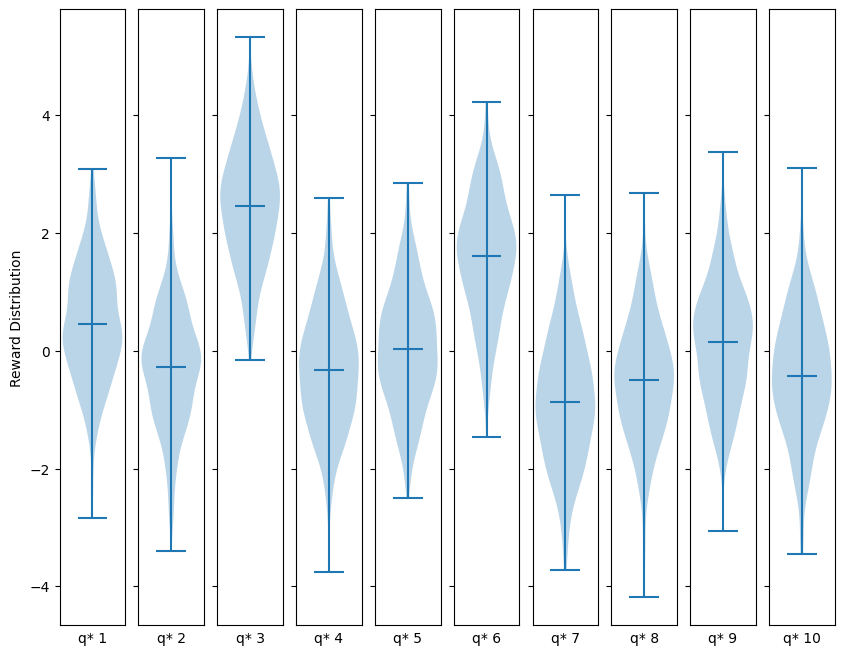

In [61]:
# Define environment with 10 arms and perform time steps
env = Environment()
%reload_ext autoreload
fig, axes = plt.subplots(1, env.arm_count, sharey=True)
axes = axes.ravel()
for k, v in enumerate(env.q_star):
    ax = axes[k]
    ax.set_xticks([])
    data = np.random.normal(v, size=500)
    ax.violinplot(data, showmeans=True)
    ax.set_xlabel('q* ' + str(k + 1))
    if k == 0:
        ax.set_ylabel('Reward Distribution')

In [62]:
# Define greedy agent class
class GreedyAgent:
    def __init__(self, arm_count):
        self.values = np.zeros(arm_count) # estimated reward of each action
        self.pull_count = np.zeros(arm_count) # number of pull for each lever
        self.arm_count = arm_count # number of arms
    def __repr__(self):
        return "Greedy"

    def select_arm(self):
        v_max = max(self.values)
        return np.random.choice(np.flatnonzero(self.values == v_max))

    def update(self, j, reward):
        self.pull_count[j] += 1
        count = self.pull_count[j]
        value = self.values[j]
        # newEstimate = oldEstimate + step_size * (target - oldEstimate)
        self.values[j] = value + (1/count) * (reward - value)

    def refresh(self):
        self.values.fill(0)
        self.pull_count.fill(0)

In [63]:
agents = [GreedyAgent(env.arm_count)]

In [64]:
# Define sampling class
class Sampling:
    def __init__(self, env_, agents_, play = 1000, run = 2000):
        self.env = env_
        self.agents = agents_
        self.play = play
        self.run = run
        self.colors = ['black', 'red', 'green', 'blue', 'magenta', 'cyan']
        self.reward_data = np.zeros((len(agents_), play, run))
        self.optimality_data = np.zeros((len(agents_), play, run))

    def start(self):
        for r in tqdm(range(self.run)):
            for p in range(self.play):
                for a in range(len(self.agents)):
                    chosen = self.agents[a].select_arm()
                    reward = self.env.reward(chosen)
                    self.agents[a].update(chosen, reward)
                    self.reward_data[a][p][r] += reward
                    if self.env.optimal_choice == chosen:
                        self.optimality_data[a][p][r] += 1
            self.env.refresh()
            for a in range(len(agents)):
                self.agents[a].refresh()

In [65]:
# Start the sampling process
sample_process = Sampling(env, agents)
sample_process.start()

100%|██████████| 2000/2000 [00:32<00:00, 61.12it/s]


In [66]:
# Define function for plotting the results of the sampling process
def plot_results(sample):
    reward_mean = np.mean(sample.reward_data, axis=2)
    optimality_mean = np.mean(sample.optimality_data, axis=2)
    time = np.array(list(range(sample.play)))

    for a in range(len(sample.agents)):
        plt.subplot(2, 1, 1)
        plt.plot(time, optimality_mean[a], '-o'
                , color=sample.colors[a], markersize=0.7, lw=1.5, label=str(sample.agents[a]))
        plt.ylabel('% Optimal Action')

        plt.subplot(2, 1, 2)
        plt.plot(time, reward_mean[a], '-o'
                , color=sample.colors[a], markersize=0.7, lw=1.5, label=str(sample.agents[a]))
        plt.ylabel('Average Reward')
        plt.xlabel('play')

    plt.legend(loc='best', fancybox=True)
    plt.show()

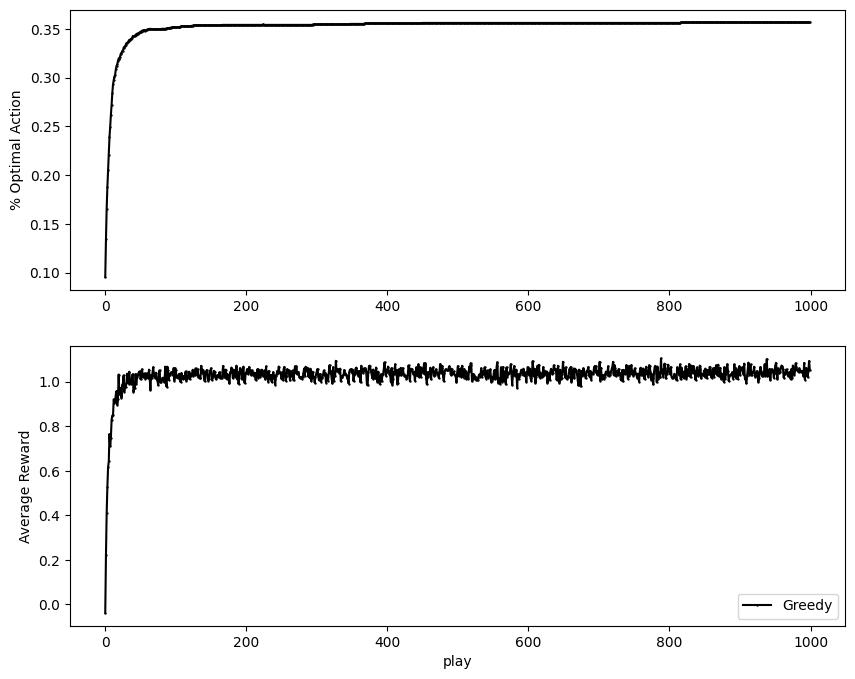

In [67]:
plot_results(sample_process)

In [68]:
# Define e-greedy agent
class EpsilonGreedyAgent:
    def __init__(self, arm_count, epsilon = 0.1):
        self.values = np.zeros(arm_count)
        self.pull_count = np.zeros(arm_count)
        self.choice = np.arange(arm_count)
        self.arm_count = arm_count
        self.epsilon = epsilon

    def __repr__(self):
        return "Epsilon= " + str(self.epsilon)

    def select_arm(self):
        if np.random.rand() > self.epsilon: # Exploit
            v_max = max(self.values)
            return np.random.choice(np.flatnonzero(self.values == v_max))
        else: # Explore
            return np.random.choice(self.choice)

    def update(self, j, reward):
        self.pull_count[j] += 1
        count = self.pull_count[j]
        value = self.values[j]
        # newEstimate = oldEstimate + step_size * (target - oldEstimate)
        self.values[j] = value + (1/count) * (reward - value)

    def refresh(self):
        self.values.fill(0)
        self.pull_count.fill(0)

In [69]:
agents = [EpsilonGreedyAgent(env.arm_count, 0.2), EpsilonGreedyAgent(env.arm_count, 0.3), GreedyAgent(env.arm_count)]
sample_process = Sampling(env, agents)
sample_process.start()

100%|██████████| 2000/2000 [01:41<00:00, 19.74it/s]


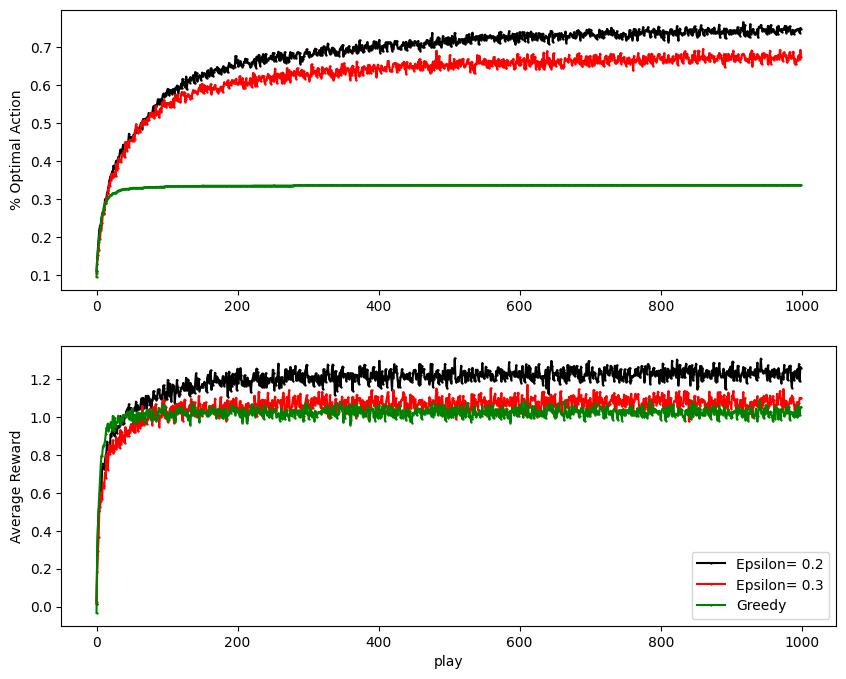

In [70]:
plot_results(sample_process)